# Projeto da Disciplina BIG DATA PARA DADOS PÚBLICOS - 2022/2

### Aluno: Arthur Cisotto Machado



### 1. Introdução

O objetivo deste projeto consiste no uso de técnicas aprendidas em aula para conduzir um projeto de análise de grandes volumes de dados.  

O projeto foi desenvolvido utilizando o Dask, uma biblioteca Python que permite a manipulação de dados em paralelo, e o Pandas, uma biblioteca Python para manipulação de dados.  

O projeto consiste na análise de dados de avaliações de livros do site Goodreads (Amazon). O dataset utilizado pode ser encontrado no [Kaggle](https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews), e consiste em 2 arquivos CSV, sendo eles:  
- "books_data.csv" - contém informações sobre os livros, como título, autor, editora, etc.
- "Books_rating.csv" - contém informações sobre as avaliações dos livros, como nota, data da avaliação, texto da avaliação, etc.

### 2. Objetivos e Contextualização
A partir dos dados da base, realizar uma análise exploratória ressaltando padrões de comportamento nos livros e suas avaliações disponíveis na base (score, gênero, data de lançamento, autor).  
  
A análise desses dados pode ser utilizada para auxiliar na tomada de decisão de compra de livros, por exemplo, para que o usuário possa escolher um livro que tenha uma boa avaliação e que esteja dentro da sua preferência de gênero, autor, etc. 
  
É interessante também observar as tendências históricas de avaliações de livros, para que se possa observar se há uma tendência de aumento ou diminuição de avaliações de livros ao longo do tempo, ou qual o ano que teve mais avaliações de livros, quais gêneros de livros tiveram mais avaliações, etc.





### 3. Desenvolvimento

### Importando as Bibliotecas Necessárias para a execução do trabalho:



In [323]:
# Para utilizar recursos do sistema
import os
import sys

# Bibliotecas DASK
import dask
from dask.distributed import Client
import dask.dataframe as dd # similar ao pandas
import dask.multiprocessing

# Bibliotecas Pandas
import pandas as pd

# Para plot
%matplotlib inline
import matplotlib.pyplot as plt

# Para processamento de dados
import nltk
nltk.download('stopwords')

# Import libraries for text manipulation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
# Import modules for evaluation purposes
# Import libraries for predcton
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tutuc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Configurando um ambiente Dask

Agora iremos configurar um ambiente Dask para execução das nossas análises. Para isso, iremos criar um **client**

In [324]:
client = Client(n_workers=3, threads_per_worker=1, memory_limit='1GB')

C:\Users\tutuc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\distributed\node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 64448 instead
  warnings.warn(


In [325]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:64448/status,
Dashboard: http://127.0.0.1:64448/status,Workers: 3
Total threads: 3,Total memory: 2.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:64449,Workers: 3
Dashboard: http://127.0.0.1:64448/status,Total threads: 3
Started: Just now,Total memory: 2.79 GiB
Comm: tcp://127.0.0.1:64476,Total threads: 1
Dashboard: http://127.0.0.1:64477/status,Memory: 0.93 GiB
Nanny: tcp://127.0.0.1:64454,


### Carregando os dados em DataFrames do Dask

In [326]:
dados_livros = dd.read_csv(f'{os.getcwd()}/Dataset/books_data.csv',
                       sep=',',
                       encoding='ISO-8859-1')

In [327]:
reviews = dd.read_csv(f'{os.getcwd()}/Dataset/Books_rating.csv',
                       sep=',',
                       encoding='ISO-8859-1',
                       dtype={'Id': 'category'})

### Amostra dos dados

In [328]:
dados_livros.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


In [329]:
reviews.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


### Dicionário de Dados

#### Descrição dos dados do dataset "books_data.csv"

| Features | Descrição |
| --- | --- |
| Title | Título do Livro |
| description | Descrição do Livro |
| authors | Nome dos autores do livro |
| image | URL da capa do livro |
| previewLink | link para acessar o livro no Google Books |
| publisher | Nome da Editora |
| publishedDate | Data de Publicação |
| infoLink | Link para obter mais informações sobre o livro |
| categories | Gêneros do livro |
| ratingsCount | Número de avaliações do livro |

#### Descrição dos dados do dataset "Books_rating.csv"

| Features | Descrição |
| --- | --- |
| id | Id do Livro |
| Title | Título do Livro |
| Price | Preço do Livro |
| User_id | Id do usuário que avaliou o livro |
| profileName | Nome do usuário que avaliou o livro |
| review/helpfulness | Avaliação de utilidade da avaliação, ex: 2/3 |
| review/score | Nota do livro de 0 a 5 |
| review/time | Data da avaliação |
| review/summary | Resumo da avaliação |
| review/text | Texto da avaliação |




### Inferindo o Schema dos DataFrames

In [330]:
dados_livros.dtypes

Title             object
description       object
authors           object
image             object
previewLink       object
publisher         object
publishedDate     object
infoLink          object
categories        object
ratingsCount     float64
dtype: object

In [331]:
reviews.dtypes

Id                    category
Title                   object
Price                  float64
User_id                 object
profileName             object
review/helpfulness      object
review/score           float64
review/time              int64
review/summary          object
review/text             object
dtype: object

### Quantidade de registros por DataFrame

In [332]:
# Verificando o tamanho do dataset
print('Tamanho do dataset Reviews:')
print(f'Número de linhas: {len(reviews)}')
print(f'Número de colunas: {len(reviews.columns)}')
print('Tamanho do dataset Dados Livros:')
print(f'Número de linhas: {len(dados_livros)}')
print(f'Número de colunas: {len(dados_livros.columns)}')


Tamanho do dataset Reviews:
Número de linhas: 3000000
Número de colunas: 10
Tamanho do dataset Dados Livros:
Número de linhas: 212404
Número de colunas: 10


### 4. Análise Exploratória - Dados do Dataset "books_data.csv"

#### 4.1. Palavras mais frequentes nos títulos dos livros

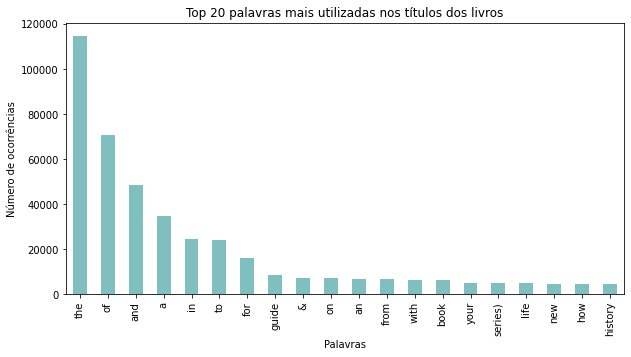

In [333]:
palavras_titulo = dados_livros['Title'].str.lower().str.cat(sep=' ').compute().split()
palavras_titulo_df = pd.DataFrame(palavras_titulo, columns=['palavras'])

top_20_palavras_porcentagem = palavras_titulo_df['palavras'].value_counts().head(20)

plt.figure(figsize=(10,5))
plt.title('Top 20 palavras mais utilizadas nos títulos dos livros')
plt.xlabel('Palavras')
plt.ylabel('Número de ocorrências')
top_20_palavras_porcentagem.plot.bar(color='teal', alpha=0.5)
plt.show()


Como pode-se observar no gráfico, as palavras mais comuns nos títulos dos livros são artigos e conectivos gramaticais (a, o, e, de, para, com, etc).
Esse resultado é esperado, pois essas palavras são muito comuns em português e inglês, e são usadas para ligar palavras e formar frases.  
Além disso, é possível observar que a palavra "The" aparece com muito mais frequêcia do que o artigo "a", o que indica que a maioria dos livros tem um substantivo definido no título.  
As palavras mais frequentes nos títulos dos livros que não são artigos e conectivos gramaticais foram:
- "guia": que indica grande presença de livros como guias de estudo ou guias de viagem 
- "livro"
- "series": que indica grande presença de livros de uma série
- "vida": que indica grande presença de biografias
- "história": que indica grande presença de livros de história de personagens famosos ou de fatos históricos


#### 4.2. Palavras mais frequentes nas descrições dos livros

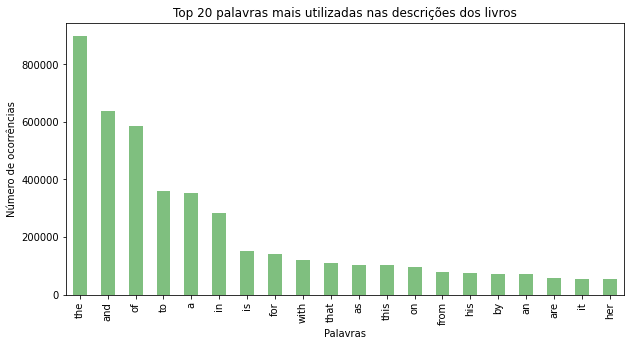

In [334]:
palavras_descricao = dados_livros['description'].str.lower().str.cat(sep=' ').compute().split()
palavras_descricao_df = pd.DataFrame(palavras_descricao, columns=['palavras'])

top_20_palavras_porcentagem = palavras_descricao_df['palavras'].value_counts().head(20)

plt.figure(figsize=(10,5))
plt.title('Top 20 palavras mais utilizadas nas descrições dos livros')
plt.xlabel('Palavras')
plt.ylabel('Número de ocorrências')
top_20_palavras_porcentagem.plot.bar(color='green', alpha=0.5)
plt.show()

Assim como no título dos livros, as palavras mais comuns nas descrições dos livros são artigos e conectivos gramaticais (a, o, e, de, para, com, etc).
Esse resultado é esperado, pois essas palavras são muito comuns em português e inglês, e são usadas para ligar palavras e formar frases.
  
Diferentemente do título dos livros, não foi possível observar uma palavra que aparece com muita frequência sem ser artigo ou conectivo gramatical.

#### 4.3. Autores mais frequentes nos livros da base de dados

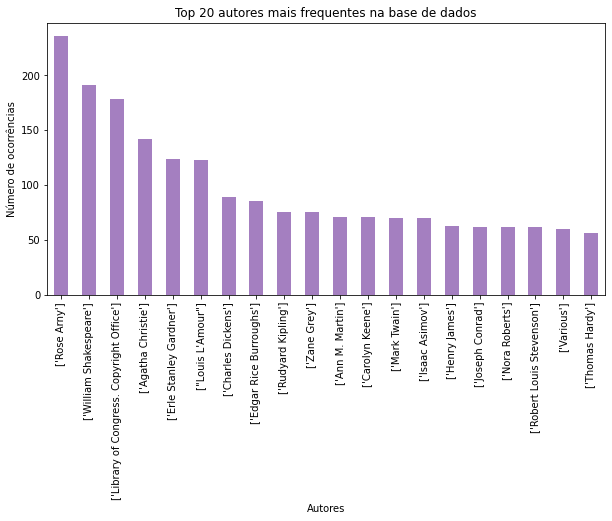

In [335]:
autores = dados_livros['authors']
autores_df = pd.DataFrame(autores.compute())
top_20_autores = autores_df['authors'].value_counts().head(20)

plt.figure(figsize=(10,5))
plt.title('Top 20 autores mais frequentes na base de dados')
plt.xlabel('Autores')
plt.ylabel('Número de ocorrências')
top_20_autores.plot.bar(color='indigo', alpha=0.5)
plt.show()


Como pode-se observar no gráfico, os autores mais frequentes nos livros da base de dados são:
- "Rose Arny" : que curiosamente é um nome fictício, e uma pesquisa rápida no Google não encontrou nenhum resultado famoso relacionado a esse nome.
- "William Shakespeare" : que é um dos autores mais famosos da literatura mundial na história da humanidade.
- "Library of Congress" : que é uma instituição que tem como objetivo preservar e disseminar o conhecimento, e que provavelmente é responsável por publicar livros de domínio público.

#### 4.4. Editoras mais frequentes nos livros da base de dados

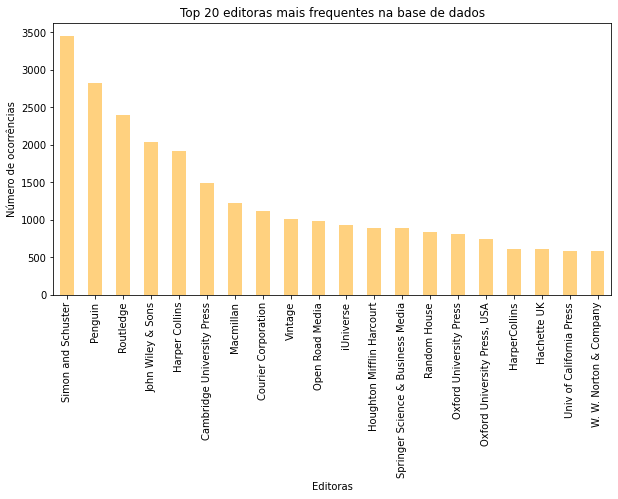

In [336]:
editoras = dados_livros['publisher']
editoras_df = pd.DataFrame(editoras.compute())
top_20_editoras = editoras_df['publisher'].value_counts().head(20)

plt.figure(figsize=(10,5))
plt.title('Top 20 editoras mais frequentes na base de dados')
plt.xlabel('Editoras')
plt.ylabel('Número de ocorrências')
top_20_editoras.plot.bar(color='orange', alpha=0.5)
plt.show()


Como pode-se observar no gráfico, as editoras mais frequentes nos livros da base de dados são:
- "Simon & Schuster" : que é uma das maiores editoras do mundo.
- "Penguin" : que é também uma das maiores editoras do mundo, famosa por publicar livros clássicos da literatura mundial.
- "Routledge" : que é uma editora britânica especializada em livros acadêmicos.


#### 4.5. Quantidade de livros lançados por ano (Data de Publicação)

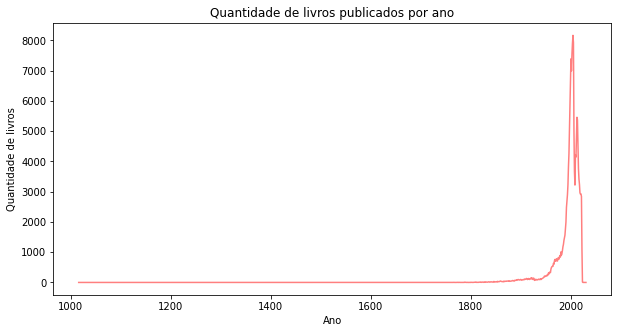

In [337]:
# group by para agrupar os livros por ano de publicação
dados_livros_ano = dados_livros.copy()
dados_livros_ano['publishedDate'] = dados_livros_ano['publishedDate'].astype(str)
dados_livros_ano['publishedDate'] = dados_livros_ano['publishedDate'].str[:4]
#Remove nan 
dados_livros_ano = dados_livros_ano[dados_livros_ano['publishedDate'] != 'nan']
#Remove os livros com caracteres que não são números
dados_livros_ano = dados_livros_ano[dados_livros_ano['publishedDate'].str.isnumeric()]
dados_livros_ano['publishedDate'] = dados_livros_ano['publishedDate'].astype(int)

# Agrupando os livros por ano de publicação
dados_livros_ano_group = dados_livros_ano.groupby('publishedDate').count().compute()
dados_livros_ano_group = dados_livros_ano_group.reset_index()
dados_livros_ano_group = dados_livros_ano_group.sort_values(by='publishedDate', ascending=True)
dados_livros_ano_group = dados_livros_ano_group.rename(columns={'Title': 'quantidade', 'publishedDate': 'ano'})
dados_livros_ano_group = dados_livros_ano_group[['ano', 'quantidade']]



plt.figure(figsize=(10,5))
plt.title('Quantidade de livros publicados por ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de livros')
plt.plot(dados_livros_ano_group['ano'], dados_livros_ano_group['quantidade'], color='red', alpha=0.5)
plt.show()



Como pode-se observar no gráfico, a quantidade de livros lançados por ano tem aumentado consideravelmente desde os anos 90.
Isso pode ser explicado pelo aumento da popularidade da internet, que possibilitou a publicação de livros de forma mais fácil e rápida, e também pelo aumento da popularidade da leitura, que possibilitou a publicação de mais livros.

O declínio radical na quantidade de livros lançados a partir de 2022 pode ser explicado pela existência de poucos livros que ainda não foram lançados, mas que já estão disponíveis para pré-venda no Google Books. Por exemplo, a base de dados contém 1 livro que está com o ano de publicação marcado como 2030.

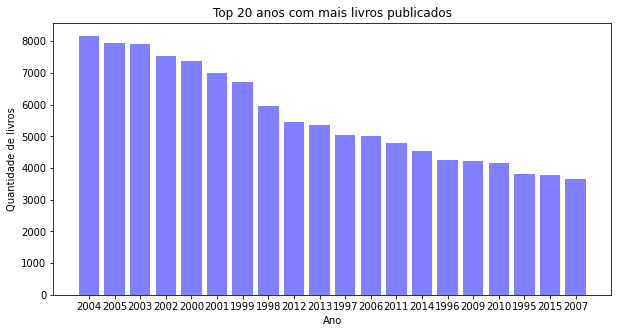

In [338]:
dados_livros_ano_group = dados_livros_ano_group.sort_values(by='quantidade', ascending=False).head(20)
dados_livros_ano_group = dados_livros_ano_group.reset_index(drop=True)

plt.figure(figsize=(10,5))
plt.title('Top 20 anos com mais livros publicados')
plt.xlabel('Ano')
plt.ylabel('Quantidade de livros')
plt.bar(dados_livros_ano_group['ano'].astype(str), dados_livros_ano_group['quantidade'], color='blue', alpha=0.5)
plt.show()




Como pode-se observar no gráfico, a quantidade de livros lançados por ano tem aumentado consideravelmente desde os anos 90. A faixa entre os anos 2000 e 2005 é a que possui a maior quantidade de livros lançados.
  
O ano de 2004 é o que possui a maior quantidade de livros lançado, com 8168 livros.

#### 4.6. Autor, Gênero e Editora mais frequente por ano nos últimos 10 anos (Data de Publicação)


In [339]:
# group by para agrupar os livro por ano

anos = dados_livros_ano['publishedDate'].unique().compute()
anos = anos.sort_values()
anos = anos[anos <= 2022]
ultimos_10_anos = anos[-10:]
autor_mais_publicado = []
editora_mais_publicada = []
generos_mais_freq = []


for ano in ultimos_10_anos:
    dados_livros_ano_filtrado = dados_livros_ano[dados_livros_ano['publishedDate'] == ano]
    
    # Verificando os gêneros mais frequentes naquele ano
    generos = dados_livros_ano_filtrado['categories']
    generos_df = pd.DataFrame(generos.compute())
    top_1_genero = generos_df['categories'].value_counts().head(1)
    generos_mais_freq.append(top_1_genero.index[0])

    # Verificando o autor mais publicado naquele ano
    autores = dados_livros_ano_filtrado['authors']
    autores_df = pd.DataFrame(autores.compute())
    top_1_autor = autores_df['authors'].value_counts().head(1)
    autor_mais_publicado.append(top_1_autor.index[0])

    # Verificando a editora mais publicada naquele ano
    editoras = dados_livros_ano_filtrado['publisher']
    editoras_df = pd.DataFrame(editoras.compute())
    top_1_editora = editoras_df['publisher'].value_counts().head(1)
    editora_mais_publicada.append(top_1_editora.index[0])



d = {'Ano': ultimos_10_anos, 'Gênero mais frequente': generos_mais_freq, 'Autor mais publicado': autor_mais_publicado, 'Editora mais publicada': editora_mais_publicada}

generos_mais_freq_df = pd.DataFrame(data=d)
generos_mais_freq_df



2022-11-29 17:07:07,736 - distributed.worker_memory - WARNING - Worker tcp://127.0.0.1:64482 (pid=20220) exceeded 95% memory budget. Restarting...
2022-11-29 17:07:07,884 - distributed.nanny - WARNING - Restarting worker


,Ano,Gênero mais frequente,Autor mais publicado,Editora mais publicada
24,2013,['Fiction'],"['Zondervan Publishing House', 'Zondervan']",Routledge
30,2014,['Fiction'],['Lauren Owen'],Open Road Media
15,2015,['Fiction'],['DK'],Routledge
12,2016,['Fiction'],['Agatha Christie'],Simon and Schuster
22,2017,['Fiction'],['Phyllis A. Whitney'],Routledge
9,2018,['Fiction'],['Wilbur Smith'],Routledge
57,2019,['Fiction'],['Rey Terciero'],Good Press
16,2020,['Fiction'],['Barry Levine'],Routledge
45,2021,['Fiction'],['Edgar Rice Burroughs'],Simon and Schuster
79,2022,['Fiction'],['Jim Kjelgaard'],DigiCat


A tabela acima mostra o autor, gênero e editora mais frequente por ano nos últimos 10 anos (Data de Publicação).
  
Como pode-se observar, o gênero mais frequente nos últimos 10 anos é "Ficção" em todos os anos.

#### 4.6. Gêneros mais frequentes nos livros da base de dados

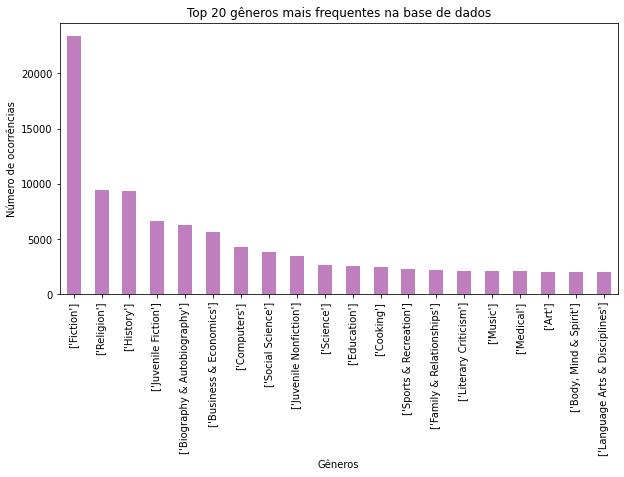

In [340]:
generos = dados_livros['categories']
generos_df = pd.DataFrame(generos.compute())
top_20_generos = generos_df['categories'].value_counts().head(20)

plt.figure(figsize=(10,5))
plt.title('Top 20 gêneros mais frequentes na base de dados')
plt.xlabel('Gêneros')
plt.ylabel('Número de ocorrências')
top_20_generos.plot.bar(color='purple', alpha=0.5)
plt.show()


Como pode-se observar no gráfico, os gêneros mais frequentes nos livros da base de dados são:

- "Ficção" : que é um gênero literário que conta uma história imaginária, com personagens fictícios, e que pode ser classificado em subgêneros como ficção científica, ficção histórica, ficção fantástica, ficção de terror, etc.
- "Religião" : que é um gênero literário que conta histórias sobre a vida de personagens religiosos, ou sobre fatos históricos relacionados a religião. Esse resultado é esperado, pois a Bíblia, por exemplo, é o livro mais vendido da história da humanidade.
- "História" : que é um gênero literário que conta histórias sobre fatos históricos, ou sobre a vida de personagens históricos. 

#### 4.7. Número de avaliações dos livros por gênero - Top 10 Gêneros com mais livros na base de dados


In [341]:
generos = dados_livros['categories']
generos_df = pd.DataFrame(generos.compute())
top_10_generos = generos_df['categories'].value_counts().head(10)
generos_list = top_10_generos.index.tolist()
lista_media_avaliacoes = []

for genero in generos_list:
    dados_livros_genero = dados_livros[dados_livros['categories'] == genero]
    notas_livros_genero = dados_livros_genero['ratingsCount']
    media_notas_livros_genero = notas_livros_genero.mean().compute()
    lista_media_avaliacoes.append(media_notas_livros_genero)

d = {'Gênero': generos_list, 'Média de número de avaliações': lista_media_avaliacoes}

nota_media_genero_df = pd.DataFrame(data=d)
nota_media_genero_df = nota_media_genero_df.sort_values(by='Média de número de avaliações', ascending=False)

nota_media_genero_df

,Gênero,Média de número de avaliações
4,['Biography & Autobiography'],38.170281
0,['Fiction'],35.336751
3,['Juvenile Fiction'],28.556301
5,['Business & Economics'],22.601770
9,['Science'],17.161560
8,['Juvenile Nonfiction'],14.865209
2,['History'],12.299735
7,['Social Science'],11.177455
1,['Religion'],10.792749
6,['Computers'],3.105780


A tabela acima mostra o número de avaliações dos livros por gênero dentre os Top 10 Gêneros com mais livros na base de dados.
  
Curiosamente, o gêneo Biografia possui em média o maior número de avaliações, mesmo tendo muito menos livros do que os gêneros Ficção e Religião.


#### 4.8. Número de avaliações dos livros por autor - Top 10 Autores com mais livros na base de dados

In [342]:
autores = dados_livros['authors']
autores_df = pd.DataFrame(autores.compute())
top_10_autores = autores_df['authors'].value_counts().head(10)
autores_list = top_10_autores.index.tolist()
lista_media_avaliacoes = []

for autor in autores_list:
    dados_livros_autor = dados_livros[dados_livros['authors'] == autor]
    notas_livros_autor = dados_livros_autor['ratingsCount']
    media_notas_livros_autor = notas_livros_autor.mean().compute()
    lista_media_avaliacoes.append(media_notas_livros_autor)

d = {'Autor': autores_list, 'Média de número de avaliações': lista_media_avaliacoes}

nota_media_autor_df = pd.DataFrame(data=d)
nota_media_autor_df = nota_media_autor_df.sort_values(by='Média de número de avaliações', ascending=False)

nota_media_autor_df

,Autor,Média de número de avaliações
8,['Rudyard Kipling'],79.897436
3,['Agatha Christie'],52.039474
6,['Charles Dickens'],35.184211
1,['William Shakespeare'],7.327273
5,"[""Louis L'Amour""]",4.250000
7,['Edgar Rice Burroughs'],3.696970
9,['Zane Grey'],2.678571
4,['Erle Stanley Gardner'],2.633333
2,['Library of Congress. Copyright Office'],1.529412
0,['Rose Arny'],1.000000


A tabela acima mostra o número de avaliações dos livros por autor dentre os Top 10 Autores com mais livros na base de dados.
  
O autor mais avaliado é "Rudyard Kipling", que é conhecido por escrever livros infantis, como "O Livro da Selva" e o poema "O Fardo do Homem Branco" símbolo do neocolonialismo britânico.
  
A segunda posição é ocupada por "Agatha Christie", que é conhecida por escrever livros de mistério, como "Assassinato no Expresso do Oriente".
  
E a terceira posição é ocupada por "Charles Dickens", conhecido por escrever clássicos de ficção, como "Oliver Twist".

#### 4.9. Número de avaliações dos livros por editora - Top 10 Editoras com mais livros na base de dados

In [343]:
editoras = dados_livros['publisher']
editoras_df = pd.DataFrame(editoras.compute())
top_10_editoras = editoras_df['publisher'].value_counts().head(10)
editoras_list = top_10_editoras.index.tolist()
lista_media_avaliacoes = []

for editora in editoras_list:
    dados_livros_editora = dados_livros[dados_livros['publisher'] == editora]
    notas_livros_editora = dados_livros_editora['ratingsCount']
    media_notas_livros_editora = notas_livros_editora.mean().compute()
    lista_media_avaliacoes.append(media_notas_livros_editora)

d = {'Editora': editoras_list, 'Média de número de avaliações': lista_media_avaliacoes}

nota_media_editora_df = pd.DataFrame(data=d)
nota_media_editora_df = nota_media_editora_df.sort_values(by='Média de número de avaliações', ascending=False)

nota_media_editora_df

,Editora,Média de número de avaliações
8,Vintage,54.849462
1,Penguin,44.384923
4,Harper Collins,43.427069
2,Routledge,35.900433
6,Macmillan,29.619772
0,Simon and Schuster,24.201982
7,Courier Corporation,15.905405
9,Open Road Media,5.875657
5,Cambridge University Press,2.364679
3,John Wiley & Sons,2.283883


A tabela acima mostra o número de avaliações dos livros por editora dentre os Top 10 Editoras com mais livros na base de dados.

Todas as editoras do Top 10 possuem, como esperado, são editoras muito conhecidas e famosas, como "Simon & Schuster", "Penguin" e "Routledge".

#### 4.10. Número de avaliações dos livros por ano nos últimos 10 anos (Data de Publicação)

In [344]:
anos = dados_livros_ano['publishedDate'].unique().compute()
anos = anos.sort_values()
anos = anos[anos <= 2022]
ultimos_10_anos = anos[-10:]
lista_media_avaliacoes = []

for ano in ultimos_10_anos:
    dados_livros_ano_filtrado = dados_livros_ano[dados_livros_ano['publishedDate'] == ano]
    notas_livros_ano = dados_livros_ano_filtrado['ratingsCount']
    media_notas_livros_ano = notas_livros_ano.mean().compute()
    lista_media_avaliacoes.append(media_notas_livros_ano)

d = {'Ano': ultimos_10_anos, 'Média de número de avaliações': lista_media_avaliacoes}

nota_media_ano_df = pd.DataFrame(data=d)
nota_media_ano_df = nota_media_ano_df.sort_values(by='Ano', ascending=False)

nota_media_ano_df

,Ano,Média de número de avaliações
79,2022,15.061776
45,2021,13.379009
16,2020,18.345254
57,2019,23.529412
9,2018,15.473350
22,2017,44.626157
12,2016,29.487179
15,2015,43.878168
30,2014,57.696292
24,2013,33.795964


A tabela acima mostra o número de avaliações dos livros por ano nos últimos 10 anos (Data de Publicação).

Como pode-se observar, o ano de 2014 é o que possui a maior média de avaliações, com 57.69 avaliações por livro, o que é esperado, pois como já foi dito anteriormente, o ano de 2014 é o que possui a maior quantidade de livros lançados.

#### 5. Análise Exploratória - Dados do Dataset "Books_rating.csv"

#### 5.1. Top 10 livros com mais avaliações na base de dados

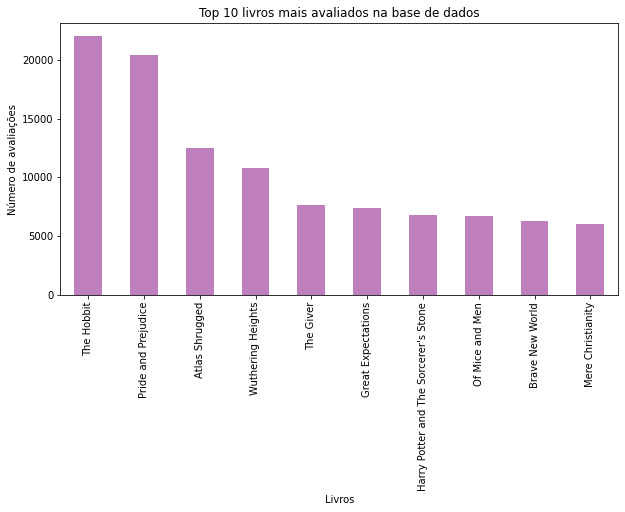

In [345]:
# CHECK most reocurring books by Id 
books = reviews['Title'].compute()
count_books = books.value_counts()
count_books = count_books.sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.title('Top 10 livros mais avaliados na base de dados')
plt.xlabel('Livros')
plt.ylabel('Número de avaliações')
count_books.plot.bar(color='purple', alpha=0.5)
plt.show()

Como pode-se observar no gráfico, os livros com mais avaliações na base de dados são:

- "The Hobbit" : que é um livro de fantasia escrito por J. R. R. Tolkien;
- "Pride and Prejudice" : que é um romance escrito por Jane Austen;
- "Atlas Shrugged" : que é um romance escrito por Ayn Rand;
- "Wuthering Heights" : que é um romance escrito por Emily Brontë;
- "The Giver" : que é um romance escrito por Lois Lowry;
- "Great Expectations" : que é um romance escrito por Charles Dickens;
- "Harry Potter and the Sorcerer's Stone" : que é um livro de fantasia escrito por J. K. Rowling;
- "Of Mice and Men" : que é um romance escrito por John Steinbeck;
- "Brave New World" : que é um romance escrito por Aldous Huxley;
- "Mere Christianity" : que é um livro de não ficção escrito por C. S. Lewis.

#### 5.2. Média de avaliações dos Top 10 livros mais avaliados na base de dados

In [346]:
books = reviews['Title'].compute()
count_books = books.value_counts()
count_books = count_books.sort_values(ascending=False).head(10)
lista_media_avaliacoes = []

for book in count_books.index:
    book_reviews = reviews[reviews['Title'] == book]
    book_reviews = book_reviews['review/score'].compute()
    book_reviews = book_reviews.mean()
    lista_media_avaliacoes.append(book_reviews)

d = {'Livro': count_books.index, 'Média de avaliações (0-5)': lista_media_avaliacoes}

nota_media_livro_df = pd.DataFrame(data=d)
nota_media_livro_df = nota_media_livro_df.sort_values(by='Média de avaliações (0-5)', ascending=False)
nota_media_livro_df

,Livro,Média de avaliações (0-5)
6,Harry Potter and The Sorcerer's Stone,4.739258
0,The Hobbit,4.657131
1,Pride and Prejudice,4.527662
9,Mere Christianity,4.469684
7,Of Mice and Men,4.350476
4,The Giver,4.273417
8,Brave New World,4.235266
5,Great Expectations,4.089880
3,Wuthering Heights,4.053711
2,Atlas Shrugged,4.028690


A tabela acima mostra a média de avaliações dos Top 10 livros mais avaliados na base de dados.
  
O livro "Harry Potter and the Sorcerer's Stone" possui a maior média de avaliações, com 4.73 de 5 estrelas.  
O livro "Atlas Shrugged" possui a menor média de avaliações, com 4.02 de 5 estrelas.

### 6. Predição de Avaliações de Livros com base no texto da avaliação

#### Seleção de Features

Em termos de análise das avaliações, o dataset fornece algumas features extrínsecas que não seram necessárias para treinar um modelo. Apenas as colunas ***review/summary***, ***review/text*** e a target  ***review/score*** foram consideradas para reduzir a complexidade.

In [347]:
reviews_processed = reviews.copy()
reviews_processed = reviews_processed[['review/summary', 'review/text', 'review/score']]
reviews_processed.head(3)

,review/summary,review/text,review/score
0,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,4.0
1,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,5.0
2,Essential for every personal and Public Library,"If people become the books they read and if ""t...",5.0


#### Pré-processamento dos dados

In [348]:
#Filtrar colunas vazias
reviews_processed = reviews_processed.dropna()
reviews_processed = reviews_processed[reviews_processed['review/summary'] != '']
reviews_processed = reviews_processed[reviews_processed['review/text'] != '']

#Converção de colunas para string
reviews_processed['review/summary'] = reviews_processed['review/summary'].astype(str)
reviews_processed['review/text'] = reviews_processed['review/text'].astype(str)

#Normalização dos textos
reviews_processed['review/summary'] = reviews_processed['review/summary'].str.lower()
reviews_processed['review/text'] = reviews_processed['review/text'].str.lower()

#Remoção de pontuação e caracteres especiais
punctuation = '[”/-@\\n:;?\"\'().,]'
reviews_processed['review/summary'] = reviews_processed['review/summary'].str.replace(punctuation, '')
reviews_processed['review/text'] = reviews_processed['review/text'].str.replace(punctuation, '')

#Remoção de tags HTML
reviews_processed['review/summary'] = reviews_processed['review/summary'].str.replace('<[^<]+?>', '')
reviews_processed['review/text'] = reviews_processed['review/text'].str.replace('<[^<]+?>', '')

#Remoção de Números
reviews_processed['review/summary'] = reviews_processed['review/summary'].str.replace(r"\d+", '')
reviews_processed['review/text'] = reviews_processed['review/text'].str.replace(r"\d+", '')



reviews_processed.head(3)

C:\Users\tutuc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\dask\dataframe\accessor.py:89: FutureWarning: The default value of regex will change from True to False in a future version.
  out = getattr(getattr(obj, accessor, obj), attr)(*args, **kwargs)
C:\Users\tutuc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\dask\dataframe\accessor.py:89: FutureWarning: The default value of regex will change from True to False in a future version.
  out = getattr(getattr(obj, accessor, obj), attr)(*args, **kwargs)
C:\Users\tutuc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\dask\dataframe\accessor.py:89: FutureWarning: The default value of regex will change from True to False in a future version.
  out = getattr(getattr(obj, accessor, obj), attr)(*args, **kwargs)
C:\U

,review/summary,review/text,review/score
0,nice collection of julie strain images,this is only for julie strain fans its a colle...,4.0
1,really enjoyed it,i dont care much for dr seuss but after readin...,5.0
2,essential for every personal and public library,if people become the books they read and if th...,5.0


In [349]:
#Remoção de stopwords
stopwords = nltk.corpus.stopwords.words('english')
reviews_processed['review/summary'] = reviews_processed['review/summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
reviews_processed['review/text'] = reviews_processed['review/text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
reviews_processed.head(3)

C:\Users\tutuc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\dask\dataframe\core.py:4005: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('review/summary', 'object'))

  warnings.warn(meta_warning(meta))
C:\Users\tutuc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\dask\dataframe\core.py:4005: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silenc

,review/summary,review/text,review/score
0,nice collection julie strain images,julie strain fans collection photos -- pages w...,4.0
1,really enjoyed,dont care much dr seuss reading philip nels bo...,5.0
2,essential every personal public library,people become books read child father man dr s...,5.0


In [350]:
## União das colunas review/summary e review/text	
reviews_processed['review/text'] = reviews_processed['review/summary'] + ' ' + reviews_processed['review/text']
reviews_processed = reviews_processed.drop(columns=['review/summary'])


#### Train/Test Split